In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, confusion_matrix, classification_report, roc_curve, roc_auc_score
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import GridSearchCV
import tensorflow.keras.metrics
import shap
import warnings
warnings.filterwarnings('ignore')

In [7]:
data = pd.read_csv('/content/drive/MyDrive/spotify top tracks/data/tracks_with_binary_target.csv')
data.set_index('title', inplace=True)
data.head()

,artist,followers,artist_popularity,year,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness,track_popularity,is_dance_pop
title,,,,,,,,,,,,,,,
"Hey, Soul Sister",Train,3.693075,78,2010,97.0,89.0,67.0,-4.0,8.0,80.0,217.0,19.0,4.0,83,0
Love The Way You Lie,Eminem,44.814807,94,2010,87.0,93.0,75.0,-5.0,52.0,64.0,263.0,24.0,23.0,82,0
TiK ToK,Kesha,6.410236,81,2010,120.0,84.0,76.0,-3.0,29.0,71.0,200.0,10.0,14.0,80,1
Bad Romance,Lady Gaga,17.680180,89,2010,119.0,92.0,70.0,-4.0,8.0,71.0,295.0,0.0,4.0,79,1
Just the Way You Are,Bruno Mars,31.020064,93,2010,109.0,84.0,64.0,-5.0,9.0,43.0,221.0,2.0,4.0,78,0


In [10]:
enc = LabelEncoder()
data['artist'] = enc.fit_transform(data['artist'])

In [11]:
data.head()

,artist,followers,artist_popularity,year,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness,track_popularity,is_dance_pop
title,,,,,,,,,,,,,,,
"Hey, Soul Sister",200,3.693075,78,2010,97.0,89.0,67.0,-4.0,8.0,80.0,217.0,19.0,4.0,83,0
Love The Way You Lie,58,44.814807,94,2010,87.0,93.0,75.0,-5.0,52.0,64.0,263.0,24.0,23.0,82,0
TiK ToK,103,6.410236,81,2010,120.0,84.0,76.0,-3.0,29.0,71.0,200.0,10.0,14.0,80,1
Bad Romance,108,17.680180,89,2010,119.0,92.0,70.0,-4.0,8.0,71.0,295.0,0.0,4.0,79,1
Just the Way You Are,26,31.020064,93,2010,109.0,84.0,64.0,-5.0,9.0,43.0,221.0,2.0,4.0,78,0


In [12]:
label = 'is_dance_pop'
features = data.columns.drop(label)
X = data[features]
Y = data[label]

<h1>1. Extreme gradient boosting for classification</h1>

In [22]:
def hyper_parameter_search(X, Y, params):
  xgb = XGBClassifier(n_jobs=-1)
  gscv = GridSearchCV(xgb, params, n_jobs=-1, scoring='f1', cv=5)
  xgboost_best = gscv.fit(X = X, y=Y)
  return xgboost_best.best_params_, xgboost_best.best_score_

In [20]:
def shap_graphs(model, X):
  expl = shap.Explainer(model, X)
  shap_values = expl(X)
  shap.plots.bar(shap_values)
  shap.plots.beeswarm(shap_values)

In [59]:
def cross_validation_model(X, Y, model):
  predicted = []
  actual = []
  folds = KFold(n_splits=5, shuffle=True, random_state=0)

  for train_ind, test_ind in folds.split(X):
    X_train = X.iloc[train_ind]
    Y_train = Y.iloc[train_ind]
    X_test = X.iloc[test_ind]
    Y_test = Y.iloc[test_ind]
    model.fit(X_train, Y_train)
    predicted_vals = model.predict(X_test)
    predicted.extend(predicted_vals)
    actual.extend(Y_test.to_list())
  
  return predicted, actual

In [33]:
def draw_roc_curve(Y_test, Y_pred):
  print(f'Roc auc score: {roc_auc_score(Y_test, Y_pred)}')
  fpr, tpr, _ = roc_curve(Y_test, Y_pred)
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, color='blue')
  x = np.arange(0.0, 1.1, 0.1)
  plt.plot(x, x, color='orange',linestyle='dashed')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  plt.show()

In [15]:
PARAMS = {
    'max_depth': [2, 3, 5, 10],
    'min_child_weight': [3, 4, 5, 6],
    'learning_rate': [0.003, 0.05, 0.1, 0.25, 0.5],
    'gamma': [0, 0.1, 0.3],
    'n_estimators': [35, 50, 100, 150, 200, 250]
}

In [23]:
xgb_params, xgb_score = hyper_parameter_search(X, Y, PARAMS)

In [25]:
print(f'best parameters: {xgb_params}')
print(f'F1 score: {xgb_score}')

best parameters: {'gamma': 0.1, 'learning_rate': 0.003, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 250}
F1 score: 0.8216513803873404


In [26]:
xgb_clf = XGBClassifier(
    max_depth = xgb_params['max_depth'],
    min_child_weight = xgb_params['min_child_weight'],
    learning_rate = xgb_params['learning_rate'],
    gamma = xgb_params['gamma'],
    n_estimators = xgb_params['n_estimators']
)

In [43]:
predicted_xgb, actual_xgb = cross_validation_model(X, Y, xgb_clf)

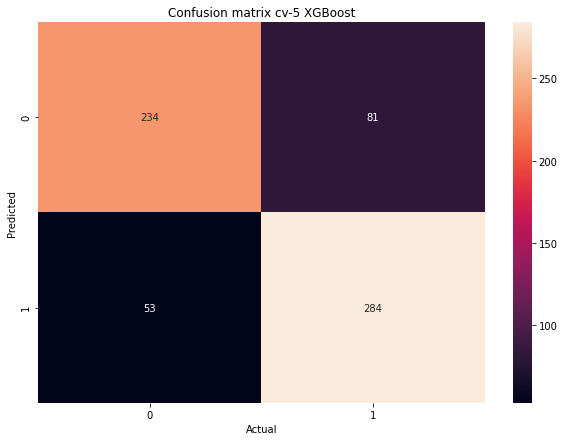

In [44]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(actual_xgb, predicted_xgb), annot=True, fmt='.5g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion matrix cv-5 XGBoost')
plt.show()

In [45]:
print(classification_report(actual_xgb, predicted_xgb))

              precision    recall  f1-score   support

           0       0.82      0.74      0.78       315
           1       0.78      0.84      0.81       337

    accuracy                           0.79       652
   macro avg       0.80      0.79      0.79       652
weighted avg       0.80      0.79      0.79       652



Roc auc score: 0.7927935565917762


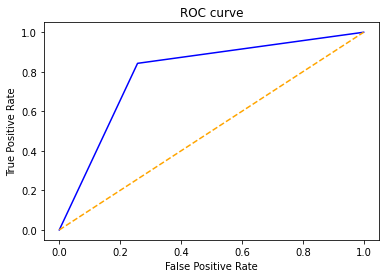

In [36]:
draw_roc_curve(actual_xgb, predicted_xgb)

The xgboost model has promissing scores but they are lower than the random forest results.

<h3>Explaining the feature importances of xgboost</h3>

In [37]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, 
    Y,
    test_size=0.2
)

In [38]:
xgb_clf.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1,
              learning_rate=0.003, max_delta_step=0, max_depth=5,
              min_child_weight=3, missing=None, n_estimators=250, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

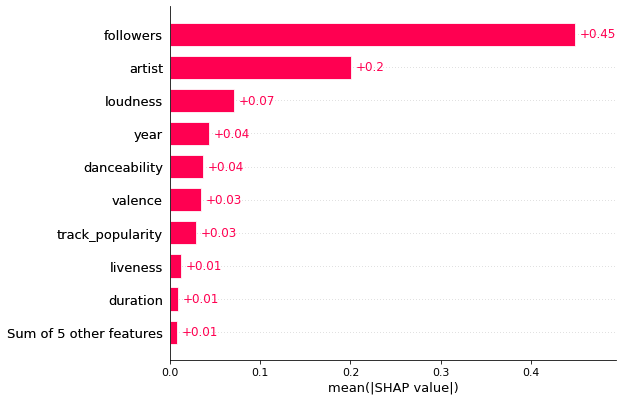

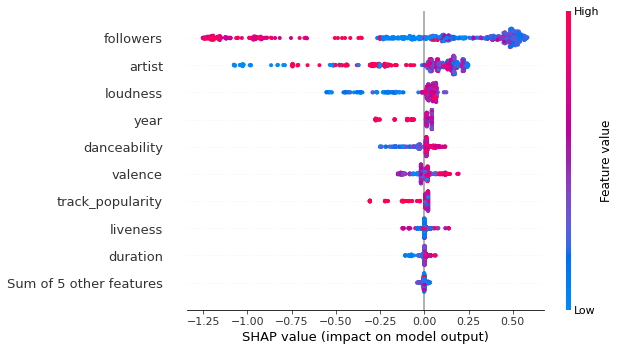

In [39]:
shap_graphs(xgb_clf, X)

The most contributing factor towards target prediction is the attribute followers. As we can see from the shap beeswarm plot, genreally artists wiht mode followers tend to decrease the predictions. In this case this means that for a song to be predicted as dance pop, the value of artist followers would generally be lower with respect to non dance pop songs.
Artist is the next most important attribute. Since the encoding does not have any particular meaning the shap plot is random, but generally one artist make songs from a small number of genres, so this is expected. Next we can see that higer values of danceability dan loudness are associated wiht dance pop songs.

<h1>2. Artificial Neural Network</h1>

In [47]:
model = Sequential()
model.add(Dense(32, input_dim=len(X.columns), kernel_initializer = 'uniform', activation='relu'))
model.add(Dense(1, kernel_initializer = 'uniform',activation='sigmoid'))

In [57]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_crossentropy']) 

In [61]:
pred_ann, actual_ann = cross_validation_model(X, Y, model)

17/17 [==============================] - 0s 2ms/step - loss: 0.6422 - binary_crossentropy: 0.6422 - auc: 0.0000e+00


In [68]:
pred_ann = np.round(pred_ann)

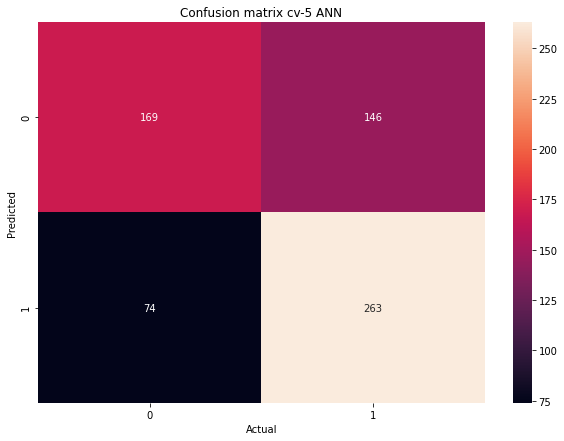

In [69]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(actual_ann, pred_ann), annot=True, fmt='.5g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion matrix cv-5 ANN')
plt.show()

In [70]:
print(classification_report(actual_ann, pred_ann))

              precision    recall  f1-score   support

           0       0.70      0.54      0.61       315
           1       0.64      0.78      0.71       337

    accuracy                           0.66       652
   macro avg       0.67      0.66      0.66       652
weighted avg       0.67      0.66      0.66       652



Roc auc score: 0.6584616833874994


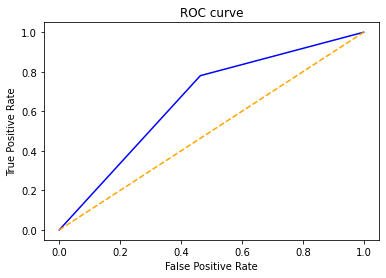

In [71]:
draw_roc_curve(actual_ann, pred_ann)

Let's try the same network but with a sigmoid activation in the hidden layer.

In [72]:
model = Sequential()
model.add(Dense(32, input_dim=len(X.columns), kernel_initializer = 'uniform', activation='sigmoid'))
model.add(Dense(1, kernel_initializer = 'uniform',activation='sigmoid'))

In [73]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_crossentropy']) 

In [74]:
pred_ann_sig, actual_ann_sig = cross_validation_model(X, Y, model)

17/17 [==============================] - 0s 1ms/step - loss: 0.6931 - binary_crossentropy: 0.6931


In [75]:
pred_ann_sig = np.round(pred_ann_sig)

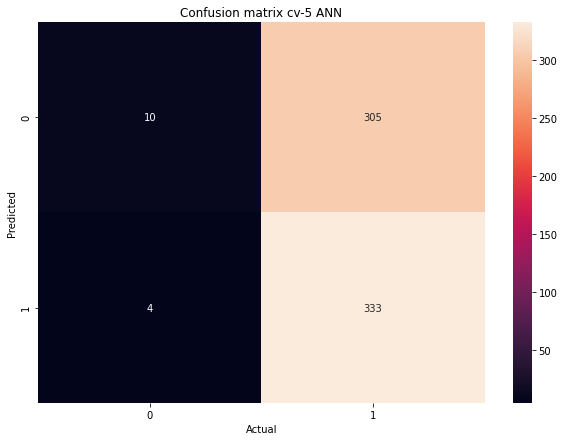

In [76]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(actual_ann_sig, pred_ann_sig), annot=True, fmt='.5g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion matrix cv-5 ANN')
plt.show()

In [78]:
print(classification_report(actual_ann_sig, pred_ann_sig))

              precision    recall  f1-score   support

           0       0.71      0.03      0.06       315
           1       0.52      0.99      0.68       337

    accuracy                           0.53       652
   macro avg       0.62      0.51      0.37       652
weighted avg       0.61      0.53      0.38       652



Roc auc score: 0.5099382977721257


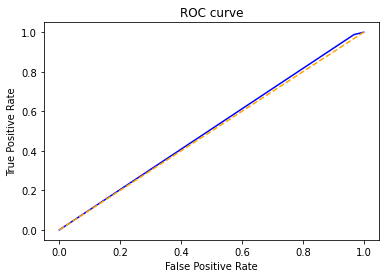

In [80]:
draw_roc_curve(actual_ann_sig, pred_ann_sig)

This network corresponds to random guessing.

<h1>3. Deep neural network</h1>

In [221]:
model = Sequential()
model.add(Dense(64, input_dim=len(X.columns), kernel_initializer = 'uniform', activation='relu'))
model.add(Dense(32, kernel_initializer = 'uniform', activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(16, kernel_initializer = 'uniform', activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(8, kernel_initializer = 'uniform', activation='relu'))
model.add(Dense(1, kernel_initializer = 'uniform',activation='sigmoid'))

In [222]:
opt = tensorflow.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy']) 

In [223]:
history = model.fit(X_train, Y_train, batch_size=32, epochs=200, validation_split=0.15)

Epoch 1/200
14/14 [==============================] - 1s 15ms/step - loss: 0.6933 - accuracy: 0.4819 - val_loss: 0.6932 - val_accuracy: 0.4810
Epoch 2/200
14/14 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.4910 - val_loss: 0.6932 - val_accuracy: 0.4810
Epoch 3/200
14/14 [==============================] - 0s 3ms/step - loss: 0.6930 - accuracy: 0.5226 - val_loss: 0.6932 - val_accuracy: 0.4810
Epoch 4/200
14/14 [==============================] - 0s 4ms/step - loss: 0.6939 - accuracy: 0.5090 - val_loss: 0.6937 - val_accuracy: 0.4810
Epoch 5/200
14/14 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5181 - val_loss: 0.6938 - val_accuracy: 0.4810
Epoch 6/200
14/14 [==============================] - 0s 3ms/step - loss: 0.6926 - accuracy: 0.5113 - val_loss: 0.6937 - val_accuracy: 0.4810
Epoch 7/200
14/14 [==============================] - 0s 3ms/step - loss: 0.6921 - accuracy: 0.5136 - val_loss: 0.6936 - val_accuracy: 0.4810
Epoch 8/200


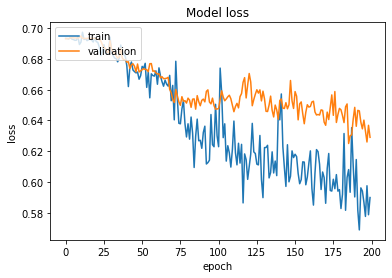

In [224]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Model loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [225]:
pred_dnn = model.predict(X_test)
pred_dnn

array([[0.65501916],
       [0.53543323],
       [0.65884924],
       [0.19402787],
       [0.52824473],
       [0.59485734],
       [0.5902939 ],
       [0.3207416 ],
       [0.10362449],
       [0.6170496 ],
       [0.5420699 ],
       [0.30454507],
       [0.59079707],
       [0.6231198 ],
       [0.6483991 ],
       [0.5481458 ],
       [0.26787406],
       [0.15552211],
       [0.5699917 ],
       [0.5721501 ],
       [0.60243565],
       [0.5275416 ],
       [0.6492415 ],
       [0.6422229 ],
       [0.64918935],
       [0.6391629 ],
       [0.26974964],
       [0.52487576],
       [0.55900085],
       [0.6487766 ],
       [0.69121015],
       [0.5225197 ],
       [0.5458429 ],
       [0.6790397 ],
       [0.6544025 ],
       [0.10015538],
       [0.5217812 ],
       [0.20567256],
       [0.22696567],
       [0.612716  ],
       [0.5367328 ],
       [0.5882629 ],
       [0.5300533 ],
       [0.6469584 ],
       [0.670072  ],
       [0.5676094 ],
       [0.11192247],
       [0.619

In [226]:
pred_dnn = np.round(pred_dnn)

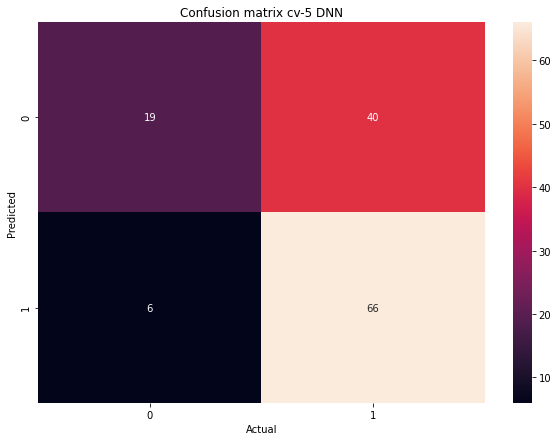

In [227]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(Y_test, pred_dnn), annot=True, fmt='.5g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion matrix cv-5 DNN')
plt.show()

In [229]:
print(classification_report(Y_test, pred_dnn))

              precision    recall  f1-score   support

           0       0.76      0.32      0.45        59
           1       0.62      0.92      0.74        72

    accuracy                           0.65       131
   macro avg       0.69      0.62      0.60       131
weighted avg       0.68      0.65      0.61       131



Roc auc score: 0.6193502824858756


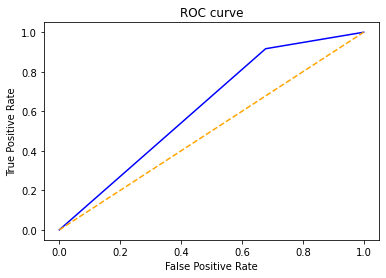

In [230]:
draw_roc_curve(Y_test, pred_dnn)